# Mean GradCam for en face images

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

set_session(tf.Session(config=config))

Using TensorFlow backend.


In [4]:
import sys
print(sys.path)
sys.path.append('gradcam')
print(sys.path)

['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', 'gradcam']


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [7]:
face_images = np.load('data/en_face.npy')

In [8]:
emotionDict7 = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}

### Load data

In [10]:
from grad_cam import visualize, get_gradcam, plot_mean_cam
from models import emoDAN
import math

In [11]:
danPath = '/home/workspace/itautkute/emotionaldan/Model2/Model2'
datasetDir = "/home/workspace/itautkute/emotionaldan/data/"
trainSet = np.load(datasetDir + "AffectnetVal_7.npz")
initLandmarks = trainSet['Landmark'][0].reshape((1,136))

In [12]:
emodan = emoDAN(initLandmarks, 50)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Mean GradCam

In [13]:
def get_cams_by_emotion(images_labels, emotion_label, tf_session):
    cams = [] 
    for batch_img, batch_lndm, batch_label in images_labels:
        if batch_label == emotion_label:
            cam_image = get_gradcam([batch_img], [batch_label], danPath,  emodan, tf_session, img_mask=0)
            cams.append(cam_image)   
    return cams

In [14]:
sess = tf.Session()   
Saver = tf.train.Saver()
Saver.restore(sess, danPath)

INFO:tensorflow:Restoring parameters from /home/workspace/itautkute/emotionaldan/Model2/Model2


In [15]:
cams_backup =[]
for em in range(1,7):
    print('Emotion:', emotionDict7[em])
    cams = get_cams_by_emotion(face_images, em, sess)
    plt.figure()
    plot_mean_cam(cams)
    cams_backup.append(cams) 
np.save('data/en_face_cams',cams_backup)

### Find images closest to mean gradcams

In [16]:
from grad_cam import get_heatmap, overlay_cam
import pickle

In [17]:
face_gradcams = np.load('data/en_face_cams.npy')

In [18]:
def get_mean_cam(cams):
    cams_num = [c for c in cams if (not np.isnan(c).any()) and (len(c)>0)]
    if len(cams_num)>0:
        cams_sum = sum(cams_num)/len(cams_num)
        cam_heatmap = cv2.applyColorMap(np.uint8(255*cams_sum), cv2.COLORMAP_JET)
        cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB) 
        imgplot = plt.imshow(cam_heatmap)
        return cams_sum

Create dictionary from image id to image.

In [19]:
id_to_img = {} 
for emotion_label in range(1,7):
    idx = 0
    for batch_img, batch_lndm, batch_label in face_images:
        if batch_label == emotion_label:
            id_to_img[emotion_label,idx] = batch_img
            idx += 1

In [20]:
with open('data/id_to_img.pkl', 'wb') as f:
        pickle.dump(id_to_img, f)

Mean Grad-CAM from all the en face images.

array([[0.00626856, 0.00766158, 0.00905459, ..., 0.00725389, 0.00613791,
        0.00502192],
       [0.00766158, 0.00936415, 0.01106672, ..., 0.00886587, 0.00750189,
        0.00613791],
       [0.00905459, 0.01106672, 0.01307885, ..., 0.01047784, 0.00886587,
        0.00725389],
       ...,
       [0.00940595, 0.01149617, 0.01358638, ..., 0.01840988, 0.01557759,
        0.0127453 ],
       [0.00795888, 0.00972752, 0.01149617, ..., 0.01557759, 0.01318104,
        0.01078449],
       [0.00651181, 0.00795888, 0.00940595, ..., 0.0127453 , 0.01078449,
        0.00882367]])

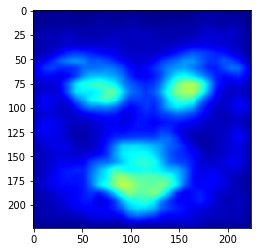

In [21]:
get_mean_cam(face_gradcams[0])

Euclidean distance between matrixes

In [22]:
def e_distance(a,b):
    return np.linalg.norm(a-b)

In [23]:
e_distance(face_gradcams[1][7], mean_happy)

22.647901198798692

Find closest gradcam to mean happy gradcam.

In [24]:
def find_closest(matrix_list, target_matrix):
    min_distance = 999999
    closest_matrix = None
    closest_id = None
    for i,m in enumerate(matrix_list):
        if len(m) > 0:
            dist = e_distance(m, target_matrix)
            if dist < min_distance:
                closest_matrix = m
                closest_id = i
                min_distance = dist
    return closest_matrix, closest_id

In [32]:
def find_closest_image_to_gradcam(emotion_id, gradcams):
    mean_gradcam = get_mean_cam(gradcams[emotion_id-1])
    res, res_i = find_closest(gradcams[emotion_id-1], mean_gradcam)
    plt.imshow(get_heatmap(mean_gradcam))
    plt.show()
    plt.imshow(get_heatmap(res))
    plt.show()
#     true_cam = get_gradcam([id_to_img[emotion_id,res_i]], [emotion_id], danPath,  emodan, sess, img_mask=0)
#     plt.imshow(get_heatmap(true_cam))
    
    plt.imshow(np.reshape(id_to_img[emotion_id,res_i], (224, 224)), cmap='gray')
    plt.show()
    overlay_cam(np.reshape(id_to_img[emotion_id,res_i], (224, 224)), res, 0.6)

Emotion: Happiness


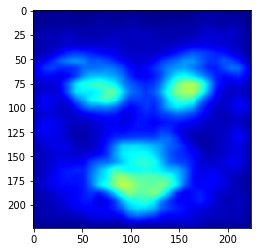

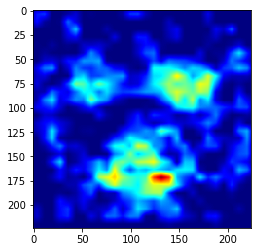

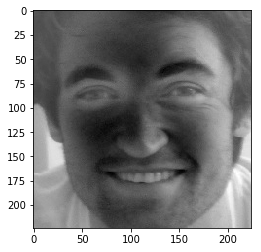

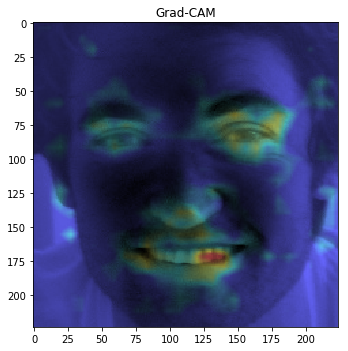

Emotion: Sadness


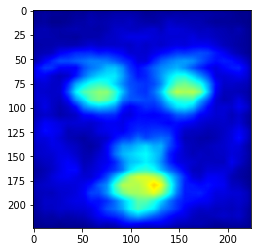

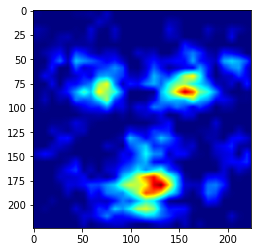

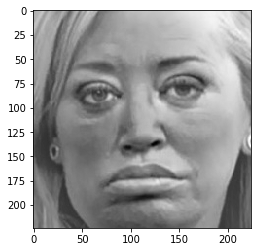

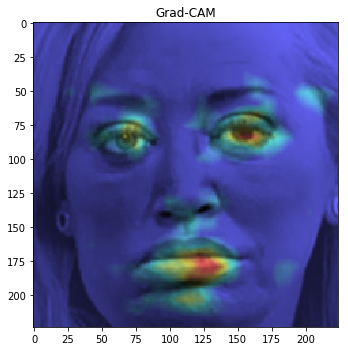

Emotion: Surprise


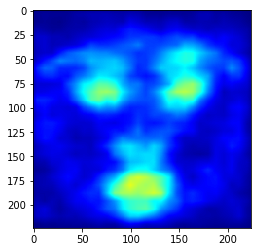

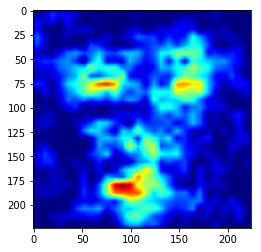

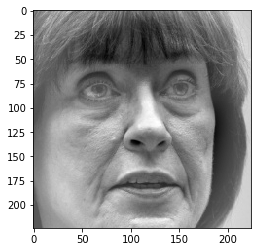

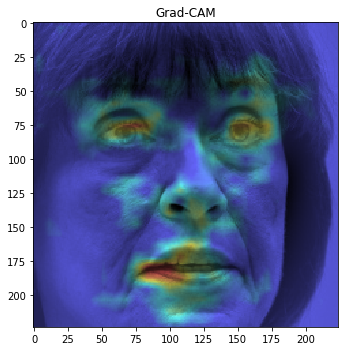

Emotion: Fear


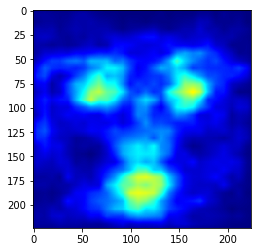

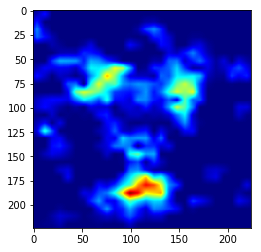

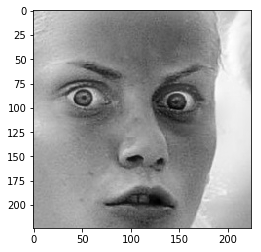

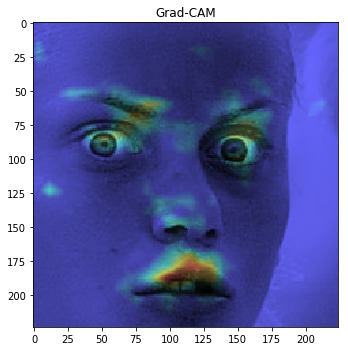

Emotion: Disgust


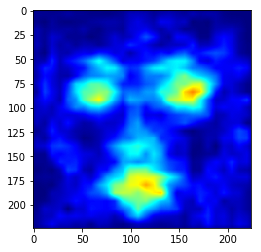

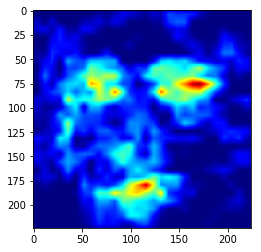

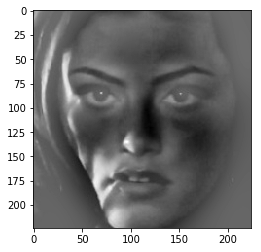

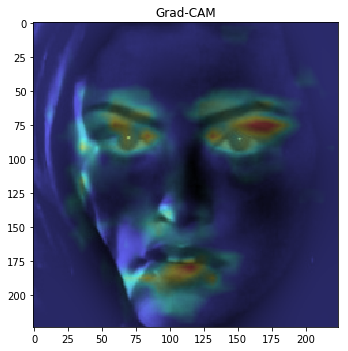

Emotion: Anger


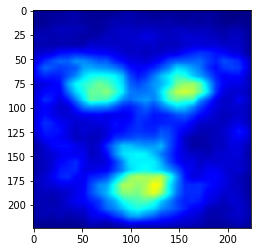

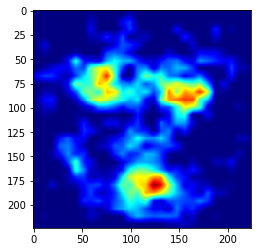

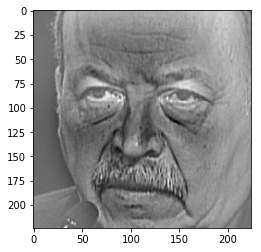

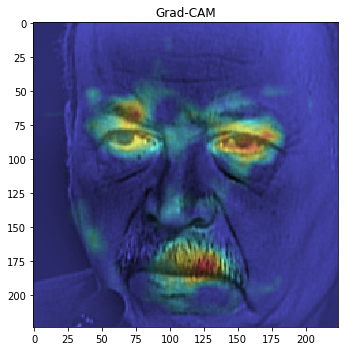

In [33]:
for em in range(1,7):
    print('Emotion:', emotionDict7[em])
    find_closest_image_to_gradcam(em, face_gradcams)

Emotion: Happiness


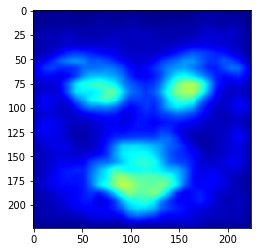

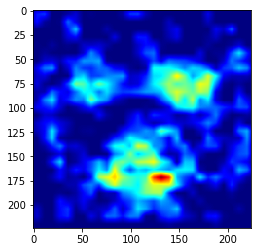

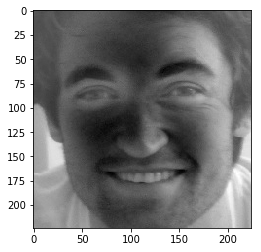

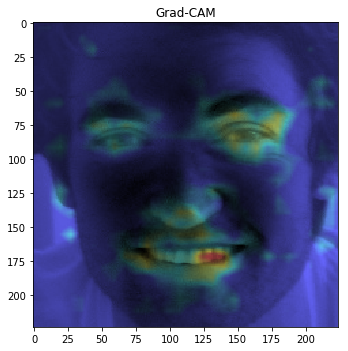

Emotion: Sadness


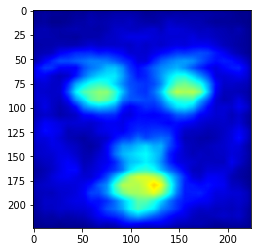

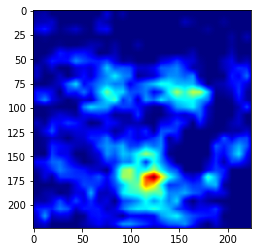

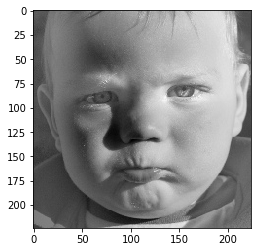

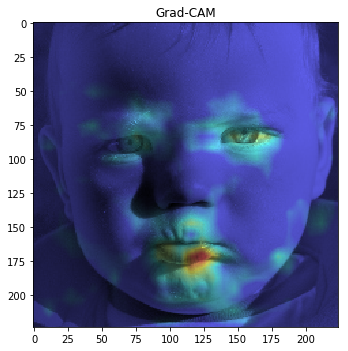

Emotion: Surprise


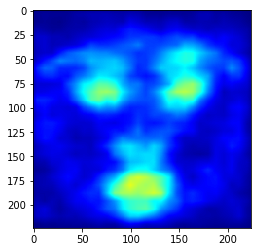

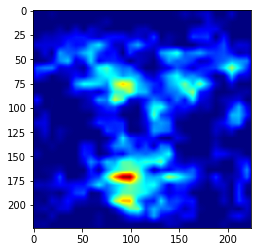

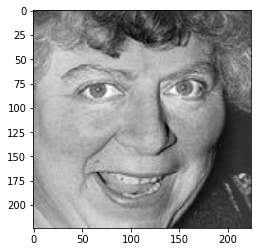

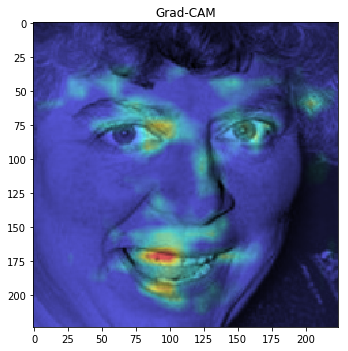

Emotion: Fear


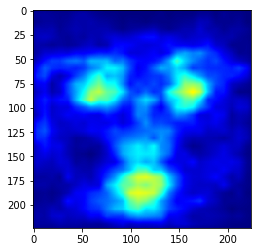

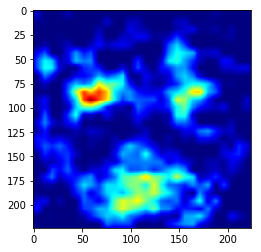

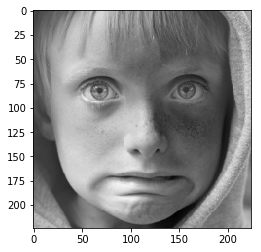

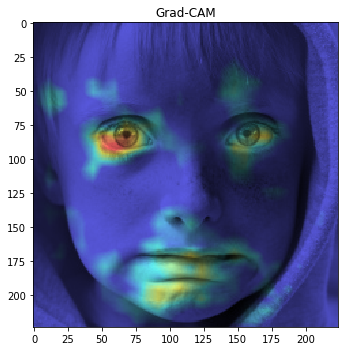

Emotion: Disgust


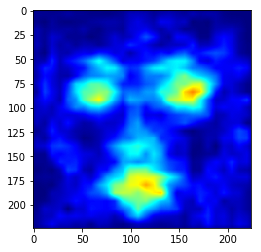

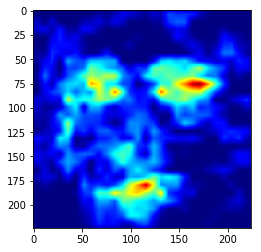

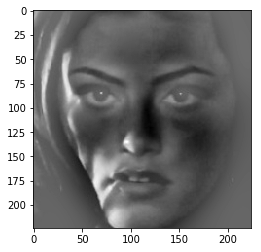

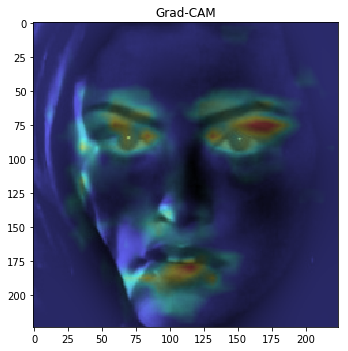

Emotion: Anger


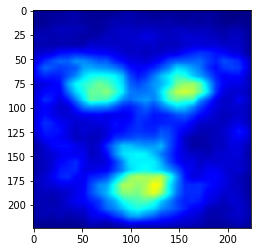

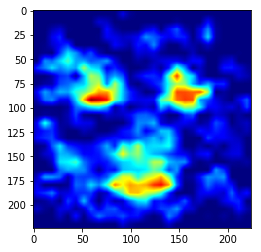

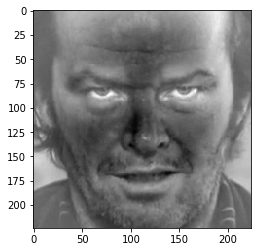

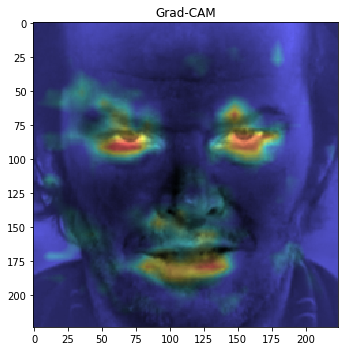

In [27]:
face_gradcams = np.load('data/en_face_cams.npy')
for em in range(1,7):
    print('Emotion:', emotionDict7[em])
    find_closest_image_to_gradcam(em, face_gradcams)